In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import glob
import re
import tensorflow as tf
from matplotlib import pyplot as plt
from lib.generator import DataGenerator
from lib.list_generator import ListGenerator, ListGenerator2
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras import regularizers
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, Concatenate

%matplotlib inline

Using TensorFlow backend.


In [2]:
# MEAN and STANDARD DIVIASION
p = re.compile('/([0-9]+)')
l = []
for file in glob.glob('./../Data/train_db/000*'):
    l1 = pd.read_csv(file, delimiter=' ', header=None)
    l1 = l1.iloc[:,2:-1] # Remove rows with '[' and ']'
    #l1['id'] = p.search(file).group(1)
    l.append(l1)
train_raw = pd.concat(l, axis=0)

mean = train_raw.mean()
disper = train_raw.std()
train_raw.shape

(2428, 400)

In [3]:
# ID_LIST
p = re.compile('/([0-9]+)')
id_list = list({p.search(file).group(1) for file in glob.glob('./../Data/train_db/*')})
len(id_list)

194

In [ ]:
def data_prep(df):
    df['key'] = 1
    df1 = df.copy(deep=True)
    #df['id'] = df.id
    df1['id1'] = df1.id
    del df1['id']
    df2 = pd.merge(df, df1, on='key')
    del df2['key']
    df2['label'] = (df2.id == df2.id1)
    return df2

In [ ]:
#*******************************
train_id_list = id_list[:140]
valid_id_list = id_list[140:]
len(train_id_list), len(valid_id_list), len(id_list)

In [ ]:

train_gen=DataGenerator(train_id_list, mean=mean, disper=disper)
valid_gen=DataGenerator(valid_id_list, mean=mean, disper=disper)

In [ ]:
a = train_gen.__getitem__(0)
type(a[1].values)

In [4]:
from keras import backend as K
def rejection(y_true, y_pred, b=0):
    return K.mean((1 - K.round(y_pred+b)) * y_true)

def acceptance(y_true, y_pred, b=0):
    return K.mean((1 - y_true) *  K.round(y_pred+b))

def eer(y_true, y_pred):
    rej = tf.reduce_sum((1 - tf.round(y_pred)) * y_true)
    accept = tf.reduce_sum((1 - y_true) *  tf.round(y_pred))
    diff = rej - accept
    diffm = tf.abs(diff)
    #delta = y_pred[y_pred * K.sign(diff) < 0.5*K.sign(diff)]
    delta = tf.boolean_mask(y_pred, y_pred * K.sign(diff) <0.5*K.sign(diff))
    ones = tf.ones(2)
    d = tf.concat([ones, tf.abs(0.5-delta)], axis=0)

    s1, _ = tf.nn.top_k(-1*d, tf.cast(diffm, dtype='int32')+1)
    s11 = -1*s1
    s2 = tf.concat([ones, s11], axis=0)
    s = (s2[-1] + s2[-2]) /2
    b = s * tf.sign(diff)
    res = K.mean(K.equal(y_true, tf.round(y_pred+b)))
    return res
    
def np_eer(y_true, y_pred):
    rej = np.sum((1 - np.round(y_pred)) * y_true)
    accept = np.sum((1 - y_true) *  np.round(y_pred))
    print('rej=%s, acc=%s' %(rej,accept))
    diff = rej - accept
    delta = y_pred[y_pred * np.sign(diff) <.5*np.sign(diff)]
    d = 0.5-delta
    print(d)
    s1 = np.sort(d)
    print(s1)
    b = (s1[int(diff)]+s1[int(diff)-1])/2
    res = np.mean(np.equal(y_true, np.round(y_pred+b)))
    return res

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',rejection, acceptance, eer])

In [ ]:
history = model.fit_generator(generator=train_gen,
                    validation_data=valid_gen,
                    epochs=50 )

In [ ]:
plt.plot(history.history['eer'])
plt.plot(history.history['val_eer'])
plt.show()

In [ ]:
history.history['rejection']

In [ ]:
res = model.evaluate_generator(valid_gen)

In [ ]:
pred = model.predict_generator(valid_gen)

In [5]:
# *** SINGLE MODEL ***
file_list = [file for file in glob.glob('./../Data/train_db/*')]
len(file_list)

52284

In [6]:
train_files, valid_files = train_test_split(file_list, test_size=0.25)
len(train_files), len(valid_files)

(39213, 13071)

In [7]:
from lib.single_generator import SingleGenerator
single_train_gen = SingleGenerator(train_files, id_list=id_list, mean=mean, disper=disper)
single_valid_gen = SingleGenerator(valid_files, id_list=id_list, mean=mean, disper=disper)

In [8]:
single_model = Sequential()
single_model.add(Dense(200, input_dim=400))
single_model.add(BatchNormalization())
single_model.add(Activation('relu'))
single_model.add(Dense(50))
single_model.add(BatchNormalization())
single_model.add(Activation('relu'))
single_model.add(Dense(194))
single_model.add(Activation('softmax'))

In [9]:
single_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
single_history = single_model.fit_generator(generator=single_train_gen,
                    validation_data=single_valid_gen,
                    epochs=20, steps_per_epoch=200, validation_steps=20 )

Epoch 1/20
200/200 [==============================] - 107s 536ms/step - loss: 4.9527 - acc: 0.0617 - val_loss: 4.4602 - val_acc: 0.1328
Epoch 2/20
200/200 [==============================] - 105s 524ms/step - loss: 3.9660 - acc: 0.2600 - val_loss: 3.3798 - val_acc: 0.3547
Epoch 3/20
200/200 [==============================] - 98s 490ms/step - loss: 2.8950 - acc: 0.4816 - val_loss: 2.3981 - val_acc: 0.5469
Epoch 4/20
200/200 [==============================] - 96s 481ms/step - loss: 1.9686 - acc: 0.6483 - val_loss: 1.5411 - val_acc: 0.7078
Epoch 5/20
200/200 [==============================] - 95s 475ms/step - loss: 1.3332 - acc: 0.7555 - val_loss: 1.1689 - val_acc: 0.7766
Epoch 6/20
200/200 [==============================] - 96s 479ms/step - loss: 0.9520 - acc: 0.8106 - val_loss: 0.8989 - val_acc: 0.8063
Epoch 7/20
200/200 [==============================] - 95s 475ms/step - loss: 0.7117 - acc: 0.8495 - val_loss: 0.8235 - val_acc: 0.8125
Epoch 8/20
200/200 [==============================] -

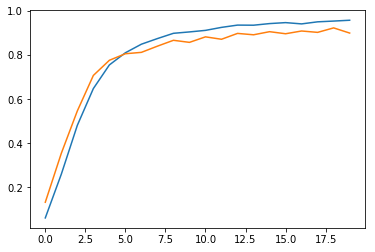

In [11]:
plt.plot(single_history.history['acc'])
plt.plot(single_history.history['val_acc'])
plt.show()

In [ ]:
single_model.layers

In [ ]:
single_model.summary()

In [12]:
for la in single_model.layers:
    la.trainable = False

In [13]:
single_model2 = Sequential()
single_model2.add(Dense(200, input_dim=400))
single_model2.add(BatchNormalization())
single_model2.add(Activation('relu'))
single_model2.add(Dense(50))
single_model2.add(BatchNormalization())
single_model2.add(Activation('relu'))
single_model2.add(Dense(194))
single_model2.add(Activation('softmax'))
single_model2.set_weights(single_model.get_weights())
for layer in single_model2.layers:
    layer.trainable = False

In [ ]:
comp_model.summary()

In [14]:
from lib.list_generator import ListGenerator2
list2_train_gen =  ListGenerator2(train_files, mean=mean, disper=disper)
list2_valid_gen = ListGenerator2(valid_files, mean=mean, disper=disper)


In [ ]:

x00 = Input(shape=(400,))
x10 = Input(shape=(400,))
x0 = single_model(x00)
x1 =single_model2(x10)
x = Concatenate(axis=1)([x0, x1])
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
res = Activation('sigmoid')(x)
comp2_model = Model(inputs=[x00, x10], outputs=[res])

In [ ]:
comp2_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',rejection, acceptance, eer])

In [ ]:
comp2_history = comp2_model.fit_generator(generator=list2_train_gen,
                    validation_data=list2_valid_gen,
                    epochs=1, steps_per_epoch=200, validation_steps=20 )

In [ ]:
plt.plot(comp2_history.history['eer'])
plt.plot(comp2_history.history['val_eer'])
plt.show()

In [15]:
out0 = single_model.layers[5].output
out1 = single_model2.layers[5].output

x = Concatenate(axis=-1)([out0, out1])
x = Dense(50)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(20)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(1)(x)
res = Activation('sigmoid')(x)

In [16]:
comp_model = Model(inputs=[single_model.input, single_model2.input], outputs=[res])

In [17]:
comp_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',rejection, acceptance, eer])

In [18]:
comp_history = comp_model.fit_generator(generator=list2_train_gen,
                    validation_data=list2_valid_gen,
                    epochs=50, steps_per_epoch=200, validation_steps=20 )

Epoch 1/50
200/200 [==============================] - 247s 1s/step - loss: 0.6292 - acc: 0.6413 - rejection: 0.1761 - acceptance: 0.1827 - eer: 0.6416 - val_loss: 0.5519 - val_acc: 0.7328 - val_rejection: 0.1187 - val_acceptance: 0.1484 - val_eer: 0.7188
Epoch 2/50
200/200 [==============================] - 235s 1s/step - loss: 0.5028 - acc: 0.7683 - rejection: 0.0923 - acceptance: 0.1394 - eer: 0.7628 - val_loss: 0.4808 - val_acc: 0.7672 - val_rejection: 0.1250 - val_acceptance: 0.1078 - val_eer: 0.7719
Epoch 3/50
200/200 [==============================] - 236s 1s/step - loss: 0.4199 - acc: 0.8091 - rejection: 0.0747 - acceptance: 0.1163 - eer: 0.8084 - val_loss: 0.3852 - val_acc: 0.8234 - val_rejection: 0.1172 - val_acceptance: 0.0594 - val_eer: 0.8406
Epoch 4/50
200/200 [==============================] - 235s 1s/step - loss: 0.3558 - acc: 0.8395 - rejection: 0.0633 - acceptance: 0.0972 - eer: 0.8387 - val_loss: 0.3169 - val_acc: 0.8641 - val_rejection: 0.0563 - val_acceptance: 0.079

200/200 [==============================] - 236s 1s/step - loss: 0.2152 - acc: 0.9103 - rejection: 0.0381 - acceptance: 0.0516 - eer: 0.9106 - val_loss: 0.2303 - val_acc: 0.9047 - val_rejection: 0.0406 - val_acceptance: 0.0547 - val_eer: 0.9000
Epoch 34/50
200/200 [==============================] - 236s 1s/step - loss: 0.2119 - acc: 0.9156 - rejection: 0.0344 - acceptance: 0.0500 - eer: 0.9144 - val_loss: 0.2028 - val_acc: 0.9203 - val_rejection: 0.0281 - val_acceptance: 0.0516 - val_eer: 0.9313
Epoch 35/50
200/200 [==============================] - 236s 1s/step - loss: 0.2187 - acc: 0.9114 - rejection: 0.0355 - acceptance: 0.0531 - eer: 0.9097 - val_loss: 0.2309 - val_acc: 0.9031 - val_rejection: 0.0234 - val_acceptance: 0.0734 - val_eer: 0.9062
Epoch 36/50
200/200 [==============================] - 236s 1s/step - loss: 0.2169 - acc: 0.9130 - rejection: 0.0359 - acceptance: 0.0511 - eer: 0.9116 - val_loss: 0.2336 - val_acc: 0.9000 - val_rejection: 0.0328 - val_acceptance: 0.0672 - val_

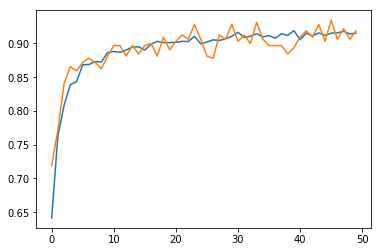

In [19]:
plt.plot(comp_history.history['eer'])
plt.plot(comp_history.history['val_eer'])
plt.show()

In [ ]:
dense1 = single_model.layers[0]
bn1 = single_model.layers[1]
act1 = single_model.layers[2]
dense2 = single_model.layers[3]
bn2 = single_model.layers[4]
act2 = single_model.layers[5]

In [ ]:
single_model.summary()

In [ ]:
for la in single_model.layers[0:6]:
    la.trainable = False

In [ ]:
dense1.trainable = False
bn1.trainable = False
act1.trainable = False
dense2.trainable = False
bn2.trainable = False
act2.trainable = False

In [ ]:
list_train_gen = ListGenerator(train_files, mean=mean, disper=disper)
list_valid_gen = ListGenerator(valid_files, mean=mean, disper=disper)

In [ ]:
# *** Compiled model ***
a1 = Input(shape=(400,))
a2 = Input(shape=(400,))
b1 = dense1(a1)
b2 = dense1(a2)
c1 = bn1(b1)
c2 = bn1(b2)
d1 = act1(c1)
d2 = act1(c2)
e1 = dense2(d1)
e2 = dense2(d2)
f1 = bn2(e1)
f2 = bn2(e2)
g1 = act2(f1)
g2 = act2(f2)

resh = Concatenate(axis=-1)([g1, g2])
j = Dense(20)(resh)
i = BatchNormalization()(j)
k = Activation('relu')(i)
l = Dense(1)(k)
res = Activation('sigmoid')(l)
compiled_model = Model(inputs=[a1, a2], outputs=[res])

In [ ]:
compiled_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy',rejection, acceptance, eer])

In [ ]:
compiled_history = compiled_model.fit_generator(generator=list_train_gen,
                    validation_data=list_valid_gen,
                    epochs=10, steps_per_epoch=200, validation_steps=20 )

In [ ]:
plt.plot(compiled_history.history['eer'])
plt.plot(compiled_history.history['val_eer'])
plt.show()

In [ ]:
p = re.compile('/([0-9]+)')
test_id_list = list({p.search(file).group(1) for file in glob.glob('./../Data/test_db/*')})
len(test_id_list)

In [ ]:
test_files = [file for file in glob.glob('./../Data/test_db/*')]
test_gen = SingleGenerator(test_files, id_list=id_list, mean=mean, disper=disper)

a = single_model.evaluate_generator(test_gen)
a

In [ ]:
test_list_gen = ListGenerator(test_files, mean=mean, disper=disper)
b = comp2_model.evaluate_generator(test_list_gen)
b

In [ ]:
single_model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
single_model2.pop()
single_model2.pop()


In [ ]:
single_model2.summary()

In [ ]:
# LAMBDA
from keras.layers import Lambda, concatenate
encoder = single_model2
inp1 = Input(shape = (400,))
inp2 = Input(shape= (400,))

enc1 = Lambda(lambda x : encoder.predict(x))(inp1)
enc2 = Lambda(lambda x : encoder.predict(x))(inp2)

inp = concatenate([enc1,enc2], axis=1)

x = Dense(100)(x)
x = Activation('relu')(x)

x = Dense(1)(x)
output = Activation('sigmoid')(x)

new_model = Model(inputs=[inp1,inp2], outputs=[output])